In [1]:
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm
import mido
import torchaudio
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

C:\Users\Zain\anaconda3\envs\musician\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\Zain\anaconda3\envs\musician\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [449]:
class WaveformDataset(Dataset):
    
    
    def __init__(self, data_dir, sequence_len, model_type, transform=None, target_transform=None):
        self.sl = sequence_len
        self.data_dir = data_dir
        self.ftype = '.' + data_dir.split('/')[-2]
        self.model_type = model_type
        self.data_dict = self.load_audio_files(data_dir, '.wav')
        
        self.x, self.y = self.load_data(self.data_dict, self.sl)
        
        self.transform = transform
        self.target_transform = target_transform
    
    def load_audio_files(self, directory, ftype):
        data = {}
        for fname in os.listdir(directory):
            if fname.endswith(ftype):
                fpath = directory + fname
                waveform, sample_rate = torchaudio.load(fpath)
                non_empty_mask = waveform.abs().sum(dim=0).bool() 
                waveform = waveform[:, non_empty_mask]
                data[fname] = {
                    'waveform': waveform, 
                    'sample_rate' : sample_rate
                }
                continue
            else:
                continue
        return data
    
    def load_data(self, data_dict, sequence_len):
        inputs, targets = [], []
        for sample in data_dict.values():
            sequences = torch.stack(self.sequence(sample['waveform'], sequence_len), dim=0)
            target = sequences[1:]
            sequences = sequences[:-1]
            inputs.append(sequences)
            targets.append(target)
        return torch.cat(inputs, dim=0), torch.cat(targets, dim=0)
    
    def sequence(self, t, sequence_len):
        return t.split(sequence_len, -1)[:-1]
                
    def __getitem__(self, idx):
        
        x = self.x[idx]
        y = self.y[idx]
    
#         if self.model_type == 'LSTM':
#             x = x.transpose(0, 1)
#             y = y.transpose(0, 1)
        
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.transform(y)
            
        sample = {'sequence': x, 'target': y}
        
        return sample
    
    def __len__(self):
        return len(self.y)        

In [450]:
import torch.nn as nn

class LSTMModel(nn.Module):
    
    def __init__(self, num_features, seq_len, hidden_size, output_size, batch_size, n_layers, device):
        super().__init__()
        self.model_type = 'LSTM'
        self.batch_size = batch_size
        self.lstm = nn.LSTM(
            num_features,
            hidden_size,
            batch_first=True,
            num_layers=n_layers
        )
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, seq_len)
        self.tanh = nn.Tanh()
        
        hidden_state = torch.zeros(n_layers, batch_size, hidden_size)
        cell_state = torch.zeros(n_layers, batch_size, hidden_size)

        hidden_state = hidden_state.to(device)
        cell_state = cell_state.to(device)
            
        self.hidden = (hidden_state, cell_state)
        
    def forward(self, x):
        
        # LSTM layer
        x, h = self.lstm(x, self.hidden)
        x = self.tanh(x)
        x = self.dropout(x)
        x = self.fc1(x)     
        
        x = self.tanh(x)
        x = self.dropout(x)
        x = self.fc2(x)
#         print(x.shape)
        return x

In [451]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):

    def __init__(self, ninp, nhead, nhid, nlayers, sequence_len, device, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.ninp = ninp

#         self.decoder = nn.Linear(ninp, sequence_len)

        self.rnn_encoder = RNNEncoder(ninp, nhid, device)
        self.rnn_decoder = RNNDecoder(nhid, sequence_len, device)
        
        self.hidden = self.rnn_encoder.initHidden(device)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, src_mask):
        
#         src = self.pos_encoder(src)
        
        output = self.transformer_encoder(src, src_mask)
#         print(f'1: {output.shape}')
        
        output, hidden = self.rnn_encoder(output, self.hidden)
#         print(f'2: {output.shape}')

        output, hidden = self.rnn_decoder(output, hidden)
#         print(f'3: {output.shape}')

        return output        
    
class RNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super(RNNEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        return output, hidden

    def initHidden(self, device):
        return torch.zeros(1, 2, self.hidden_size, device=device)
    
class RNNDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, device):
        super(RNNDecoder, self).__init__()
        self.hidden_size = hidden_size

        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = self.tanh(output)
        output = self.out(output)
        return output, hidden

    def initHidden(self, device):
        return torch.zeros(1, 2, self.hidden_size, device=device)
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [452]:
wav_path = '../data/wav/'
SEQUENCE_LENGTH = 6000
BATCH_SIZE = 128
HIDDEN_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_EPOCHS = 500

In [453]:
dataset = WaveformDataset(wav_path, SEQUENCE_LENGTH, 'Transformer')

train_len = int(len(dataset)*0.8)
lengths = [train_len, len(dataset)-train_len]

trainset, validset = random_split(dataset, lengths)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../data/wav/'

In [398]:
sample = next(iter(trainloader))

In [399]:
sample['sequence'].shape

torch.Size([128, 2, 6000])

In [400]:
ninp = sample['sequence'].shape[-1]
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
transformer_model = TransformerModel(ninp, nhead, nhid, nlayers, SEQUENCE_LENGTH, DEVICE, dropout)

In [443]:
lstm_model = LSTMModel(ninp, SEQUENCE_LENGTH, HIDDEN_SIZE, 2, BATCH_SIZE, 2, DEVICE)

In [444]:
# mask = transformer_model.generate_square_subsequent_mask(sample['sequence'].size(0))
# output = transformer_model(sample['sequence'].to(DEVICE), mask)

In [445]:
model = lstm_model.to(DEVICE)

In [446]:
output = model(sample['sequence'].to(DEVICE))

In [447]:
criterion = nn.L1Loss().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

In [448]:
for epoch in range(N_EPOCHS):
    model.train()
    train_loss = 0.0
    for sample in tqdm(trainloader):
        x, y = sample['sequence'].to(DEVICE), sample['target'].to(DEVICE)

        optimizer.zero_grad()
        if model.model_type == 'Transformer':
            mask = model.generate_square_subsequent_mask(x.size(0)).to(DEVICE)
            output = model(x, mask)
        else:
            output = model(x)

        loss = criterion(output, y)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(trainloader)
    
    model.eval()
    valid_loss = 0.0
    for sample in tqdm(validloader):
        x, y = sample['sequence'].to(DEVICE), sample['target'].to(DEVICE)

        with torch.no_grad():
            if model.model_type == 'Transformer':
                mask = model.generate_square_subsequent_mask(x.size(0)).to(DEVICE)
                output = model(x, mask)
            else:
                output = model(x)

        error = criterion(output, y)
        valid_loss += error.item()
    valid_loss = valid_loss / len(validloader)
    
    print(f'{epoch} - train: {train_loss}, valid: {valid_loss}')

 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 139.87it/s]

0 - train: 0.1022228171988841, valid: 0.09898651192585627


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 141.38it/s]

1 - train: 0.09834185771403774, valid: 0.09924333194891612


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 139.87it/s]

2 - train: 0.0978734889818776, valid: 0.09785849750041961


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 144.10it/s]

3 - train: 0.09688081616355528, valid: 0.09725881914297739


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.73it/s]

4 - train: 0.09561398685459167, valid: 0.09610870629549026


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.73it/s]

5 - train: 0.0940404137776744, valid: 0.09556004405021667


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.73it/s]

6 - train: 0.09308063058603194, valid: 0.09452258100112279


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 141.38it/s]

7 - train: 0.09205442222376023, valid: 0.09392531762520472


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.73it/s]

8 - train: 0.0914122071718016, valid: 0.09417577137549718


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 139.65it/s]

9 - train: 0.09075961394175407, valid: 0.09359197666247686


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.73it/s]

10 - train: 0.09026255518678696, valid: 0.09327403903007507


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 130.72it/s]

11 - train: 0.0896752021245418, valid: 0.0925446793437004


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 131.96it/s]

12 - train: 0.08924477475304757, valid: 0.0926360934972763


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.05it/s]

13 - train: 0.08905469614171213, valid: 0.09334695537885031


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 139.99it/s]

14 - train: 0.08871710973401223, valid: 0.09297024259964624


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 141.38it/s]

15 - train: 0.08832018678226779, valid: 0.09237593462069829


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 141.38it/s]

16 - train: 0.08816886236590724, valid: 0.09280569950739542


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.72it/s]

17 - train: 0.087920795164762, valid: 0.09225489894549052


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 138.49it/s]

18 - train: 0.08760859841300596, valid: 0.09273656010627747


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 134.49it/s]

19 - train: 0.08743370348407377, valid: 0.09225259025891622


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.73it/s]

20 - train: 0.08720720463222073, valid: 0.09251470615466435


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 141.38it/s]

21 - train: 0.08721891358014076, valid: 0.09287212391694387


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.73it/s]

22 - train: 0.08689834261613508, valid: 0.09240670452515284


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 141.23it/s]

23 - train: 0.08674837624834429, valid: 0.09180890719095866


 45%|████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 28/62 [00:00<00:00, 137.61it/s]

24 - train: 0.08669885019621541, valid: 0.09241110732158025


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 138.49it/s]

25 - train: 0.08663645627037171, valid: 0.09205144941806793


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 140.06it/s]

26 - train: 0.08643574712257232, valid: 0.09268860171238581


 45%|████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 28/62 [00:00<00:00, 137.93it/s]

27 - train: 0.08641209188968904, valid: 0.09212469508250555


 45%|████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 28/62 [00:00<00:00, 135.80it/s]

28 - train: 0.08633270955854846, valid: 0.09268036435047786


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.73it/s]

29 - train: 0.08611570827422603, valid: 0.09245368341604869


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 139.18it/s]

30 - train: 0.0860940924575252, valid: 0.09235566010077795


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.85it/s]

31 - train: 0.0859331198998036, valid: 0.09247699131568272


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 138.41it/s]

32 - train: 0.08597423340524396, valid: 0.09280755420525869


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 137.13it/s]

33 - train: 0.08593974743158586, valid: 0.0920224999388059


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 141.38it/s]

34 - train: 0.08560541572590027, valid: 0.09181377838055292


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 141.38it/s]

35 - train: 0.08555555439764453, valid: 0.09216498484214147


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 135.80it/s]

36 - train: 0.08560981204913508, valid: 0.09220015307267507


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.73it/s]

37 - train: 0.08563438875059928, valid: 0.09227941979964574


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.73it/s]

38 - train: 0.08540443787651678, valid: 0.09218234171470006


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 138.49it/s]

39 - train: 0.08536491891549479, valid: 0.09197920610507329


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 138.49it/s]

40 - train: 0.08523734695007724, valid: 0.09133808910846711


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 137.13it/s]

41 - train: 0.08522560531573911, valid: 0.09232769409815471


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 137.13it/s]

42 - train: 0.08537596680464284, valid: 0.09217682679494223


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 137.13it/s]

43 - train: 0.08498841920687307, valid: 0.09227496534585952


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 140.06it/s]

44 - train: 0.08490231296708507, valid: 0.09259323279062907


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 138.49it/s]

45 - train: 0.08503457122752743, valid: 0.0916775385538737


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 139.87it/s]

46 - train: 0.08495218535104106, valid: 0.09242393672466279


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 139.87it/s]

47 - train: 0.0849370957622605, valid: 0.09187879612048468


 47%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 29/62 [00:00<00:00, 141.30it/s]

48 - train: 0.08496178205936186, valid: 0.09166026761134466


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.73it/s]

49 - train: 0.08485928982976944, valid: 0.09222336113452911


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 138.49it/s]

50 - train: 0.08486365611034055, valid: 0.09189683943986893


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 137.13it/s]

51 - train: 0.08469559817064193, valid: 0.09270994812250137


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 141.38it/s]

52 - train: 0.08462096955026349, valid: 0.09200622687737146


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 141.38it/s]

53 - train: 0.08468187780630204, valid: 0.09194475909074147


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 137.13it/s]

54 - train: 0.08449789364972422, valid: 0.0920062522093455


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.73it/s]

55 - train: 0.08455370018078436, valid: 0.09246753255526224


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 137.13it/s]

56 - train: 0.0845261549036349, valid: 0.09162714978059133


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 144.10it/s]

57 - train: 0.08447167181199597, valid: 0.09224701722462972


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 142.04it/s]

58 - train: 0.08442980075074781, valid: 0.09267739554246267


 24%|█████████████████████████████████████████████                                                                                                                                             | 15/62 [00:00<00:00, 141.38it/s]

59 - train: 0.08446994988668349, valid: 0.09177090376615524


 15%|███████████████████████████▎                                                                                                                                                                | 9/62 [00:00<00:00, 89.92it/s]

60 - train: 0.08445759153654499, valid: 0.09242030282815297


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 104.67it/s]

61 - train: 0.08439008194592691, valid: 0.0916665588816007


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 113.10it/s]

62 - train: 0.08428255372470425, valid: 0.09237715750932693


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 116.47it/s]

63 - train: 0.0843035249460128, valid: 0.09267935852209727


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 117.54it/s]

64 - train: 0.08429391285584818, valid: 0.09269669453303019


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 115.28it/s]

65 - train: 0.08419574472692705, valid: 0.09238870988289515


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 105.67it/s]

66 - train: 0.08423756916196115, valid: 0.09274892807006836


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 108.81it/s]

67 - train: 0.08422087241084344, valid: 0.0925464982787768


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 106.70it/s]

68 - train: 0.08407651909416722, valid: 0.09269021898508072


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 115.28it/s]

69 - train: 0.08418210872238682, valid: 0.09239385773738225


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 122.88it/s]

70 - train: 0.08412383604914911, valid: 0.09220539679129919


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 118.91it/s]

71 - train: 0.08411682457212478, valid: 0.09290492236614227


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 109.90it/s]

72 - train: 0.08406959762496333, valid: 0.09295765707890193


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 113.10it/s]

73 - train: 0.0840269368021719, valid: 0.0919050802787145


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 115.34it/s]

74 - train: 0.083871707079872, valid: 0.09232082267602285


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 125.60it/s]

75 - train: 0.08384066916281177, valid: 0.09230030924081803


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

76 - train: 0.08380162667843603, valid: 0.0922795444726944


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.33it/s]

77 - train: 0.0839841238433315, valid: 0.09217322121063869


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

78 - train: 0.0838535122813717, valid: 0.09234479963779449


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

79 - train: 0.08380782916661232, valid: 0.09296299815177918


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.33it/s]

80 - train: 0.08378278572232492, valid: 0.09266939808924993


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 113.11it/s]

81 - train: 0.0837658588444033, valid: 0.09244272063175837


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

82 - train: 0.08382869439740334, valid: 0.09209798872470856


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.88it/s]

83 - train: 0.08375334859855714, valid: 0.09234064817428589


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.16it/s]

84 - train: 0.0836814548219404, valid: 0.09249242395162582


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.70it/s]

85 - train: 0.08369889987572547, valid: 0.0924914558728536


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 117.54it/s]

86 - train: 0.08368939017095874, valid: 0.09299051364262899


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

87 - train: 0.08365922733660668, valid: 0.09269568274418513


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

88 - train: 0.08373013523317152, valid: 0.09276616076628368


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

89 - train: 0.08361567977455354, valid: 0.09231484433015187


 45%|████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 28/62 [00:00<00:00, 122.44it/s]

90 - train: 0.08370364096856886, valid: 0.09239325076341628


 45%|████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 28/62 [00:00<00:00, 132.18it/s]

91 - train: 0.08356321771298686, valid: 0.0927957942088445


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 129.88it/s]

92 - train: 0.08353034022354311, valid: 0.09241341302792232


 45%|████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 28/62 [00:00<00:00, 133.44it/s]

93 - train: 0.08353563049627889, valid: 0.0922883023818334


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

94 - train: 0.08351904838796585, valid: 0.09191229790449143


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 137.13it/s]

95 - train: 0.08347673690126788, valid: 0.09174573570489883


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

96 - train: 0.08341259509325027, valid: 0.09225550889968873


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 133.21it/s]

97 - train: 0.0835007596160135, valid: 0.09242921670277914


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.59it/s]

98 - train: 0.08342878688727656, valid: 0.09251318573951721


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

99 - train: 0.08336158986053159, valid: 0.0929976503054301


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 129.91it/s]

100 - train: 0.0834862097136436, valid: 0.09239228218793868


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 130.72it/s]

101 - train: 0.08329699488897477, valid: 0.09248803009589514


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

102 - train: 0.0834358374197637, valid: 0.091950756808122


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 131.96it/s]

103 - train: 0.08339062657567763, valid: 0.0927723228931427


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.59it/s]

104 - train: 0.08330574860015223, valid: 0.09246106495459874


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 129.88it/s]

105 - train: 0.08340289503816635, valid: 0.09288488427797953


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 133.21it/s]

106 - train: 0.08331409024615441, valid: 0.09251412947972616


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 131.96it/s]

107 - train: 0.08339132536803523, valid: 0.09291974604129791


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

108 - train: 0.08329943711719205, valid: 0.09265086154143015


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 128.07it/s]

109 - train: 0.0833109583585493, valid: 0.09253089378277461


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

110 - train: 0.08341988031902621, valid: 0.09245035896698633


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

111 - train: 0.08329282664964276, valid: 0.09238055497407913


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

112 - train: 0.0832553343667138, valid: 0.09249844551086425


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 130.72it/s]

113 - train: 0.08321437660244203, valid: 0.09265271822611491


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 128.07it/s]

114 - train: 0.08322763995778176, valid: 0.09251853227615356


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.39it/s]

115 - train: 0.08334988812285085, valid: 0.0922661304473877


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.85it/s]

116 - train: 0.08306183521786044, valid: 0.09314381231864294


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.58it/s]

117 - train: 0.0832127975600381, valid: 0.09246278454860052


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 122.84it/s]

118 - train: 0.08309625341526923, valid: 0.09262536913156509


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 119.16it/s]

119 - train: 0.0831281152223387, valid: 0.09226959496736527


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

120 - train: 0.08308767707597825, valid: 0.0920598030090332


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

121 - train: 0.08315104174037133, valid: 0.0926650529106458


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

122 - train: 0.0831235692866387, valid: 0.09202963213125864


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.18it/s]

123 - train: 0.08311214382129331, valid: 0.09170877089103063


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 130.72it/s]

124 - train: 0.08312553011121289, valid: 0.09306332021951676


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.04it/s]

125 - train: 0.08309560100878438, valid: 0.0927337646484375


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

126 - train: 0.08301035915651629, valid: 0.09230591108401616


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

127 - train: 0.08302420221509473, valid: 0.0928517093261083


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

128 - train: 0.08295449145859288, valid: 0.09235110382239024


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

129 - train: 0.08303637045525736, valid: 0.09279629786809286


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

130 - train: 0.08306719062309112, valid: 0.09253745377063752


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

131 - train: 0.08299448857865026, valid: 0.09270901679992676


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

132 - train: 0.08295532676481432, valid: 0.09289748917023341


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 116.40it/s]

133 - train: 0.08299884548591029, valid: 0.09251111696163813


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.63it/s]

134 - train: 0.08284937410104659, valid: 0.09300290048122406


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

135 - train: 0.08305269756144093, valid: 0.09274188280105591


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 117.14it/s]

136 - train: 0.0829205043133228, valid: 0.09253816505273184


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.89it/s]

137 - train: 0.0829480481484244, valid: 0.09260440518458685


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 125.27it/s]

138 - train: 0.08291389697021054, valid: 0.09239352891842524


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.33it/s]

139 - train: 0.08295614729004522, valid: 0.09248497436443964


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

140 - train: 0.08281118915446344, valid: 0.09272926847139994


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

141 - train: 0.0827839053686588, valid: 0.09282267242670059


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

142 - train: 0.08287785034025869, valid: 0.09256841093301774


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

143 - train: 0.08263840093728035, valid: 0.0929425964752833


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 125.77it/s]

144 - train: 0.08287496972949274, valid: 0.0927921732266744


 23%|██████████████████████████████████████████                                                                                                                                                | 14/62 [00:00<00:00, 129.81it/s]

145 - train: 0.0827786143748991, valid: 0.0923435777425766


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

146 - train: 0.08262336530512379, valid: 0.09216994593540827


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 125.31it/s]

147 - train: 0.08281219053652979, valid: 0.09218312402566274


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 120.71it/s]

148 - train: 0.08278500276707834, valid: 0.09256827533245086


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

149 - train: 0.08287375360246628, valid: 0.09266491035620371


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 112.05it/s]

150 - train: 0.08277608370107989, valid: 0.09269951830307642


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.10it/s]

151 - train: 0.0826658536830256, valid: 0.09284715851147969


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

152 - train: 0.08260067287952669, valid: 0.09272882044315338


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

153 - train: 0.08272614077694955, valid: 0.09278957098722458


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

154 - train: 0.08276812275571208, valid: 0.09302290777365367


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.39it/s]

155 - train: 0.08270465967155272, valid: 0.09310508221387863


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.61it/s]

156 - train: 0.08272847857686781, valid: 0.09240610152482986


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 129.88it/s]

157 - train: 0.08265762968409446, valid: 0.092501034339269


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

158 - train: 0.08267425265043013, valid: 0.09274472246567408


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

159 - train: 0.08277653650410714, valid: 0.09247977882623673


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 120.25it/s]

160 - train: 0.08263107617535899, valid: 0.09257699300845464


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.33it/s]

161 - train: 0.08266264452568946, valid: 0.09260323643684387


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 124.03it/s]

162 - train: 0.08260254694088813, valid: 0.09304413646459579


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.11it/s]

163 - train: 0.08270914480090141, valid: 0.09244007716576258


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

164 - train: 0.08265405869291674, valid: 0.09223270863294601


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.95it/s]

165 - train: 0.08258600653179231, valid: 0.09298003067572912


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

166 - train: 0.0824970246082352, valid: 0.09294454505046208


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 114.15it/s]

167 - train: 0.08250282079942765, valid: 0.09235276331504186


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

168 - train: 0.08251957487194769, valid: 0.09269048124551774


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

169 - train: 0.08245933993208793, valid: 0.09269176125526428


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 114.18it/s]

170 - train: 0.08243981448392715, valid: 0.09256492952505747


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

171 - train: 0.08247511521462471, valid: 0.09282718598842621


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 121.82it/s]

172 - train: 0.08245768109636922, valid: 0.09242452085018157


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

173 - train: 0.08252245091622876, valid: 0.09323072731494904


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 125.38it/s]

174 - train: 0.08261228773382402, valid: 0.09272315849860509


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

175 - train: 0.08255865821434606, valid: 0.09270472625891367


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.33it/s]

176 - train: 0.08258238206467321, valid: 0.09235721131165822


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

177 - train: 0.08249935267433044, valid: 0.09257380316654841


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

178 - train: 0.08252597492068045, valid: 0.09245621860027313


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 123.30it/s]

179 - train: 0.08238453598272416, valid: 0.09248551627000173


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

180 - train: 0.08254117350424489, valid: 0.09247464537620545


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 128.37it/s]

181 - train: 0.08242692954597934, valid: 0.09252862334251404


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

182 - train: 0.08245724295416186, valid: 0.0930573359131813


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

183 - train: 0.08246589488079471, valid: 0.09267051964998245


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

184 - train: 0.08227560717251993, valid: 0.09316701342662176


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.82it/s]

185 - train: 0.08232394185277724, valid: 0.09324398040771484


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 123.91it/s]

186 - train: 0.08244620960566305, valid: 0.09307304918766021


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 117.22it/s]

187 - train: 0.08238538594976548, valid: 0.09367455293734868


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

188 - train: 0.08239183574914932, valid: 0.0934122696518898


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

189 - train: 0.08234075228533437, valid: 0.09277941733598709


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 121.14it/s]

190 - train: 0.08241135735184915, valid: 0.0927813082933426


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.45it/s]

191 - train: 0.08233934616850268, valid: 0.09263305415709813


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

192 - train: 0.08230819829529332, valid: 0.09276340951522191


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

193 - train: 0.08232842217529973, valid: 0.09216027011473973


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 120.06it/s]

194 - train: 0.08236290923049373, valid: 0.09281580845514933


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

195 - train: 0.08229397838154147, valid: 0.09293436904748281


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 123.54it/s]

196 - train: 0.08232997970715646, valid: 0.09298690458138784


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

197 - train: 0.08223282822197484, valid: 0.09292266716559729


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

198 - train: 0.0822752138539668, valid: 0.0923988123734792


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 118.66it/s]

199 - train: 0.08232791361308867, valid: 0.09364680349826812


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

200 - train: 0.08230000674243897, valid: 0.09267652382453283


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 115.28it/s]

201 - train: 0.08224884901315935, valid: 0.09366074999173482


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

202 - train: 0.08235131624725557, valid: 0.09302717546621958


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 125.57it/s]

203 - train: 0.08233237302591724, valid: 0.09313433766365051


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 118.65it/s]

204 - train: 0.08220942895258626, valid: 0.09244192639986674


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.82it/s]

205 - train: 0.08236493879268246, valid: 0.09320563226938247


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 104.67it/s]

206 - train: 0.08214815549792782, valid: 0.09202005863189697


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 125.31it/s]

207 - train: 0.08222010275048594, valid: 0.09294658303260803


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

208 - train: 0.08229997549806872, valid: 0.0928144281109174


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 113.10it/s]

209 - train: 0.08218663714585765, valid: 0.09251750310262044


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

210 - train: 0.08227685634647647, valid: 0.0923367202281952


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

211 - train: 0.08217611115786337, valid: 0.09268153558174769


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

212 - train: 0.08233331516385078, valid: 0.09256398876508078


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.33it/s]

213 - train: 0.08217207234232657, valid: 0.09222514728705088


 37%|█████████████████████████████████████████████████████████████████████                                                                                                                     | 23/62 [00:00<00:00, 113.12it/s]

214 - train: 0.082227511511695, valid: 0.0928987314303716


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

215 - train: 0.08223440017431013, valid: 0.09291431506474813


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 117.54it/s]

216 - train: 0.08230542367504488, valid: 0.09260337501764297


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

217 - train: 0.0820862727780496, valid: 0.09281175831953685


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 125.98it/s]

218 - train: 0.08216940563532614, valid: 0.0924652248620987


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 113.10it/s]

219 - train: 0.08213885032361554, valid: 0.09267771691083908


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.88it/s]

220 - train: 0.08212961725169612, valid: 0.09281763633092245


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 114.39it/s]

221 - train: 0.08220481548097826, valid: 0.0928470144669215


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 123.35it/s]

222 - train: 0.08221439007789857, valid: 0.0930424913764


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

223 - train: 0.0820380013075567, valid: 0.09267706274986268


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.08it/s]

224 - train: 0.08220458871895267, valid: 0.09328580399354298


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

225 - train: 0.08210257621061418, valid: 0.09311451017856598


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 122.38it/s]

226 - train: 0.08212073183348102, valid: 0.09277933984994888


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

227 - train: 0.08204438705598155, valid: 0.09270715912183126


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.67it/s]

228 - train: 0.08220240617952039, valid: 0.09243214875459671


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

229 - train: 0.08211634416253336, valid: 0.09278057863314947


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 125.74it/s]

230 - train: 0.08212791755795479, valid: 0.09288872331380844


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.34it/s]

231 - train: 0.08200017194594106, valid: 0.09247813771168391


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 121.92it/s]

232 - train: 0.08205731068888018, valid: 0.0929019570350647


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

233 - train: 0.08207380002544772, valid: 0.09275769144296646


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.11it/s]

234 - train: 0.08200138182409349, valid: 0.09269695629676183


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

235 - train: 0.08205227601912714, valid: 0.09314047942558924


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.39it/s]

236 - train: 0.08202411258412946, valid: 0.09291849484046301


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

237 - train: 0.0820405995172839, valid: 0.09283945163091024


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.60it/s]

238 - train: 0.08196770724269652, valid: 0.09300152162710826


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

239 - train: 0.08191580577723441, valid: 0.09268463949362436


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

240 - train: 0.0819622918723091, valid: 0.09268284986416499


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 120.81it/s]

241 - train: 0.08211052093294359, valid: 0.09324931055307388


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.10it/s]

242 - train: 0.08194046611747434, valid: 0.09269657681385676


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 104.67it/s]

243 - train: 0.08203863148247043, valid: 0.09295142044623693


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

244 - train: 0.08202049292383655, valid: 0.09329992880423864


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.46it/s]

245 - train: 0.08205061982716283, valid: 0.09267358084519704


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 115.28it/s]

246 - train: 0.08187110457689531, valid: 0.09255474507808685


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.59it/s]

247 - train: 0.08189108439030186, valid: 0.09279167950153351


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

248 - train: 0.08195130659207221, valid: 0.09265366345643997


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 121.69it/s]

249 - train: 0.08201774462096152, valid: 0.09285743832588196


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

250 - train: 0.08192049171174726, valid: 0.09346311042706172


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

251 - train: 0.0819940252169486, valid: 0.0925710101922353


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

252 - train: 0.08189686183487216, valid: 0.09228864113489786


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 116.40it/s]

253 - train: 0.08173158572566125, valid: 0.0927438313762347


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

254 - train: 0.08203693659555528, valid: 0.09289490630229315


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 119.40it/s]

255 - train: 0.08178831733042194, valid: 0.09274087150891622


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 116.07it/s]

256 - train: 0.08187300351358229, valid: 0.092813378572464


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 123.90it/s]

257 - train: 0.08190445842281464, valid: 0.09222759157419205


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 121.93it/s]

258 - train: 0.08193632131142001, valid: 0.09236417263746262


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.02it/s]

259 - train: 0.08192771156468699, valid: 0.09253520021835963


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.21it/s]

260 - train: 0.0817538832704867, valid: 0.09278683513402938


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 118.42it/s]

261 - train: 0.08192023022040244, valid: 0.09234820206960043


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 117.54it/s]

262 - train: 0.08181718099982507, valid: 0.0925437072912852


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

263 - train: 0.0818279088745194, valid: 0.09285377264022827


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 120.52it/s]

264 - train: 0.08187419584681911, valid: 0.09259907205899556


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 128.07it/s]

265 - train: 0.08191798891751997, valid: 0.09317583640416463


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

266 - train: 0.08176051777216696, valid: 0.09333197375138601


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 116.40it/s]

267 - train: 0.08190911816012475, valid: 0.09262610524892807


 16%|██████████████████████████████▏                                                                                                                                                            | 10/62 [00:00<00:00, 91.66it/s]

268 - train: 0.08175042343716468, valid: 0.09232729921738307


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.39it/s]

269 - train: 0.08181310529189725, valid: 0.0925942783554395


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 113.10it/s]

270 - train: 0.08185756194495386, valid: 0.09224331676959992


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 109.33it/s]

271 - train: 0.08183625376512928, valid: 0.0930897648135821


 35%|██████████████████████████████████████████████████████████████████                                                                                                                        | 22/62 [00:00<00:00, 107.86it/s]

272 - train: 0.08168584973581376, valid: 0.09301555156707764


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 128.07it/s]

273 - train: 0.08182756662849457, valid: 0.09328528642654418


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

274 - train: 0.08177629473709291, valid: 0.09276571621497472


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

275 - train: 0.08173368943314399, valid: 0.09290745109319687


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 114.18it/s]

276 - train: 0.0817065748476213, valid: 0.09244764645894368


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

277 - train: 0.0816327326240078, valid: 0.09250596264998118


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 116.40it/s]

278 - train: 0.08177606737421404, valid: 0.09339306702216467


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 120.80it/s]

279 - train: 0.08172002735157166, valid: 0.09273182551066081


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 125.60it/s]

280 - train: 0.08177633871955256, valid: 0.09271156887213389


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 114.99it/s]

281 - train: 0.08166246596843965, valid: 0.0933971588810285


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 129.88it/s]

282 - train: 0.08176862123993135, valid: 0.09257113734881083


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

283 - train: 0.08176059347967948, valid: 0.09292308042446772


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 122.19it/s]

284 - train: 0.08175080846394261, valid: 0.09227109352747599


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

285 - train: 0.08174005511306948, valid: 0.09307682116826375


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 116.40it/s]

286 - train: 0.08169536412723603, valid: 0.09283517797787984


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

287 - train: 0.0816938026297477, valid: 0.09278647204240163


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

288 - train: 0.08168697309109473, valid: 0.09286628514528275


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 114.18it/s]

289 - train: 0.08171095134269807, valid: 0.09312018106381098


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 117.54it/s]

290 - train: 0.08167654984901028, valid: 0.09287429352601369


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 108.81it/s]

291 - train: 0.08156411325739275, valid: 0.09204427649577458


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.04it/s]

292 - train: 0.0817144098541429, valid: 0.09262934376796086


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

293 - train: 0.08190285823037548, valid: 0.09280839065710704


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.95it/s]

294 - train: 0.08165224701646835, valid: 0.09258181403080622


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

295 - train: 0.08165981524413632, valid: 0.09243840624888738


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 120.93it/s]

296 - train: 0.0816120196494364, valid: 0.09261606037616729


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 123.33it/s]

297 - train: 0.0815754535217439, valid: 0.09280230700969697


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

298 - train: 0.08157988565583382, valid: 0.09292652855316798


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 116.40it/s]

299 - train: 0.08165783687464652, valid: 0.09247561544179916


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 116.40it/s]

300 - train: 0.08154801687886638, valid: 0.09309773494799932


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 120.26it/s]

301 - train: 0.08154622225030776, valid: 0.09262698590755462


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

302 - train: 0.08155655872917944, valid: 0.09353099813063939


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

303 - train: 0.08150868862867355, valid: 0.09229617814222972


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

304 - train: 0.08166811831535832, valid: 0.0932540679971377


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.42it/s]

305 - train: 0.08174140462952276, valid: 0.09280113826195399


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 105.67it/s]

306 - train: 0.08154475027995725, valid: 0.0929246112704277


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

307 - train: 0.08148374925217321, valid: 0.09257070819536845


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 117.80it/s]

308 - train: 0.08161208454158998, valid: 0.09302935898303985


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 119.40it/s]

309 - train: 0.08156678308883021, valid: 0.09313941697279612


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

310 - train: 0.0816652123485842, valid: 0.09301360249519348


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

311 - train: 0.0816273275882967, valid: 0.09335282842318217


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

312 - train: 0.081540773232137, valid: 0.09337702095508575


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.11it/s]

313 - train: 0.0816012135436458, valid: 0.09313563853502274


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

314 - train: 0.08158380321917995, valid: 0.09295260061820348


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

315 - train: 0.08159616325170763, valid: 0.09251801073551177


 35%|██████████████████████████████████████████████████████████████████                                                                                                                        | 22/62 [00:00<00:00, 109.90it/s]

316 - train: 0.08148953955500357, valid: 0.0929356391231219


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

317 - train: 0.08152058191837804, valid: 0.09300390034914016


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.88it/s]

318 - train: 0.08150870581307719, valid: 0.09284962217013042


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 115.74it/s]

319 - train: 0.08154861653043378, valid: 0.09293917020161947


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

320 - train: 0.08163363113999367, valid: 0.09323734641075135


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 117.54it/s]

321 - train: 0.08148331459491484, valid: 0.09339020649592082


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 122.38it/s]

322 - train: 0.08144696068859869, valid: 0.09258296390374501


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

323 - train: 0.08152298725420429, valid: 0.09303546895583471


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

324 - train: 0.08162109217336101, valid: 0.09264379590749741


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

325 - train: 0.08146339114154538, valid: 0.09287498046954473


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

326 - train: 0.08145980152391619, valid: 0.09277338981628418


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.69it/s]

327 - train: 0.08155524105794969, valid: 0.09316877822081247


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

328 - train: 0.08152092788969317, valid: 0.09308033833901087


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

329 - train: 0.08140957067089696, valid: 0.09267250299453736


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

330 - train: 0.0815778861363088, valid: 0.09278340091307959


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.39it/s]

331 - train: 0.08142856856988322, valid: 0.09289388457934061


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

332 - train: 0.08147306980625275, valid: 0.09362284590800603


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.82it/s]

333 - train: 0.08142108025570069, valid: 0.0929970920085907


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 116.20it/s]

334 - train: 0.08129596409778442, valid: 0.09254336804151535


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

335 - train: 0.08142933393678357, valid: 0.09266036450862884


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 114.18it/s]

336 - train: 0.08145571079465651, valid: 0.09266217003266017


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.60it/s]

337 - train: 0.08135550661433127, valid: 0.0929205929239591


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

338 - train: 0.08148039637073394, valid: 0.09234012415011723


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

339 - train: 0.0813916418100557, valid: 0.09246195256710052


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.11it/s]

340 - train: 0.0813757831290845, valid: 0.09344649761915207


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

341 - train: 0.08134676275714751, valid: 0.09299052953720092


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 120.79it/s]

342 - train: 0.08140457157165773, valid: 0.09267608523368835


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 115.28it/s]

343 - train: 0.08142030539531861, valid: 0.09296786735455195


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

344 - train: 0.08154017213852174, valid: 0.09318872590859731


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 116.60it/s]

345 - train: 0.08130889434006906, valid: 0.09303848793109258


 16%|██████████████████████████████▏                                                                                                                                                            | 10/62 [00:00<00:00, 98.92it/s]

346 - train: 0.08145026598245866, valid: 0.09325544933478037


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.25it/s]

347 - train: 0.08139956646388577, valid: 0.09269391596317292


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

348 - train: 0.08136205988064889, valid: 0.09299219449361165


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.27it/s]

349 - train: 0.08140317386677189, valid: 0.09296504457791646


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.33it/s]

350 - train: 0.08133827270038667, valid: 0.0926067883769671


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 116.33it/s]

351 - train: 0.08139639936627881, valid: 0.092590561012427


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

352 - train: 0.08138859692600466, valid: 0.09263518104950587


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 117.54it/s]

353 - train: 0.08141094578369971, valid: 0.093223304549853


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 115.28it/s]

354 - train: 0.08136152920703735, valid: 0.09259324471155803


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

355 - train: 0.08129159673567742, valid: 0.0931162362297376


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.75it/s]

356 - train: 0.08142599787923598, valid: 0.0925529549519221


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 123.77it/s]

357 - train: 0.08136320078084545, valid: 0.09316047231356303


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.82it/s]

358 - train: 0.08145962967987984, valid: 0.0929958755771319


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 119.93it/s]

359 - train: 0.08132981833431029, valid: 0.09327061374982198


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 129.88it/s]

360 - train: 0.0812890846883097, valid: 0.09345713555812836


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 123.59it/s]

361 - train: 0.08133409869286322, valid: 0.09328754345575968


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

362 - train: 0.08132612813384302, valid: 0.09279239773750306


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

363 - train: 0.08136344088181373, valid: 0.09352369705835978


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 112.05it/s]

364 - train: 0.08131097365290887, valid: 0.09319409926732382


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.85it/s]

365 - train: 0.081310479991859, valid: 0.09267416894435883


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 117.54it/s]

366 - train: 0.08123115654433927, valid: 0.09237734327713648


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

367 - train: 0.08124904406647529, valid: 0.09329448342323303


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.04it/s]

368 - train: 0.08145077358330449, valid: 0.09264567643404006


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

369 - train: 0.08129012284259643, valid: 0.09335752179225286


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.02it/s]

370 - train: 0.08139807322332936, valid: 0.0929230625430743


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 103.19it/s]

371 - train: 0.08119328764657821, valid: 0.09339975814024608


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.88it/s]

372 - train: 0.08130027906548593, valid: 0.0928684949874878


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

373 - train: 0.08139935280046155, valid: 0.09257111102342605


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

374 - train: 0.08120182264716394, valid: 0.0930344487229983


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.33it/s]

375 - train: 0.08133112771376487, valid: 0.09250100801388422


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 116.40it/s]

376 - train: 0.0812064763759413, valid: 0.09290940562884013


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 119.54it/s]

377 - train: 0.08129539028290779, valid: 0.09270283232132594


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

378 - train: 0.08127266204645557, valid: 0.09287695288658142


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

379 - train: 0.08125407837571637, valid: 0.09300471196571986


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.82it/s]

380 - train: 0.08124076418818967, valid: 0.09287553479274115


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 114.18it/s]

381 - train: 0.08129213930618379, valid: 0.0930055449406306


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

382 - train: 0.08120917492816525, valid: 0.09278688927491506


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

383 - train: 0.08128997899832265, valid: 0.0916406994064649


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 116.16it/s]

384 - train: 0.08127350672598808, valid: 0.09318149437506994


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.46it/s]

385 - train: 0.0813013774252707, valid: 0.09285362909237543


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 108.81it/s]

386 - train: 0.08128498554710419, valid: 0.09285544753074645


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.39it/s]

387 - train: 0.08121001588240746, valid: 0.09279890358448029


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.92it/s]

388 - train: 0.08114793920709241, valid: 0.09338709165652594


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

389 - train: 0.08115918477696757, valid: 0.09296576480070749


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 117.38it/s]

390 - train: 0.0812574353429579, valid: 0.09314549416303634


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 122.17it/s]

391 - train: 0.08128101066235573, valid: 0.09238907595475515


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 116.40it/s]

392 - train: 0.08122955094422063, valid: 0.0925705169637998


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 112.05it/s]

393 - train: 0.08132290575773485, valid: 0.09265005042155584


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 117.54it/s]

394 - train: 0.08126716820463058, valid: 0.09274791181087494


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.85it/s]

395 - train: 0.081267433661607, valid: 0.092963079114755


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

396 - train: 0.08126724331128982, valid: 0.0926421528061231


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

397 - train: 0.0811263732612133, valid: 0.09288427531719208


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

398 - train: 0.08112492712755356, valid: 0.09263454675674439


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

399 - train: 0.08115806454612363, valid: 0.09310284604628881


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.57it/s]

400 - train: 0.08119532946617372, valid: 0.09257459491491318


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 119.11it/s]

401 - train: 0.08116794233360598, valid: 0.0937124694387118


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.41it/s]

402 - train: 0.08116296714832706, valid: 0.09336999406417211


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

403 - train: 0.08117187047196973, valid: 0.0929986427227656


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.39it/s]

404 - train: 0.08117812078806662, valid: 0.09265242417653402


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

405 - train: 0.08110631990336603, valid: 0.09304245909055074


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 116.40it/s]

406 - train: 0.08121253273660137, valid: 0.09297037323315939


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 112.05it/s]

407 - train: 0.08114131828469615, valid: 0.09293655206759771


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

408 - train: 0.08120477992680765, valid: 0.09286483178536097


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 113.11it/s]

409 - train: 0.08097329567517003, valid: 0.09274609386920929


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.18it/s]

410 - train: 0.0811401552730991, valid: 0.09309043685595195


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 101.76it/s]

411 - train: 0.08114942511723887, valid: 0.09307693193356197


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 111.01it/s]

412 - train: 0.08110876297277789, valid: 0.09285772442817689


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 115.28it/s]

413 - train: 0.08115965836951809, valid: 0.0930326834321022


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 117.54it/s]

414 - train: 0.08123325532482516, valid: 0.09342105835676193


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

415 - train: 0.08111153290637078, valid: 0.09373052517573038


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 111.17it/s]

416 - train: 0.08100644018380873, valid: 0.09320955226818721


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

417 - train: 0.08109732452900179, valid: 0.09220547080039979


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.33it/s]

418 - train: 0.08115462502164225, valid: 0.09264491846164068


 35%|██████████████████████████████████████████████████████████████████                                                                                                                        | 22/62 [00:00<00:00, 106.52it/s]

419 - train: 0.08115788885662632, valid: 0.09329536060492198


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 115.28it/s]

420 - train: 0.08097100798641482, valid: 0.09318070362011592


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

421 - train: 0.08108857418260267, valid: 0.09317092895507813


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 117.34it/s]

422 - train: 0.08114846964036265, valid: 0.09305401543776194


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 118.91it/s]

423 - train: 0.08107160236085614, valid: 0.09313218295574188


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 119.54it/s]

424 - train: 0.08098789532819102, valid: 0.09238809794187545


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

425 - train: 0.08105971676207357, valid: 0.09321624338626862


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 125.38it/s]

426 - train: 0.08112420370021174, valid: 0.09286941885948181


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 115.28it/s]

427 - train: 0.08103837902026792, valid: 0.09266088008880616


 16%|██████████████████████████████▏                                                                                                                                                            | 10/62 [00:00<00:00, 94.25it/s]

428 - train: 0.08116825453696712, valid: 0.09318182816108068


 15%|███████████████████████████▎                                                                                                                                                                | 9/62 [00:00<00:00, 85.77it/s]

429 - train: 0.08100790518426126, valid: 0.09293822844823202


 16%|██████████████████████████████▏                                                                                                                                                            | 10/62 [00:00<00:00, 99.91it/s]

430 - train: 0.08115248081664886, valid: 0.0931830366452535


 18%|█████████████████████████████████                                                                                                                                                         | 11/62 [00:00<00:00, 107.74it/s]

431 - train: 0.08111126564683453, valid: 0.09218717863162358


 35%|██████████████████████████████████████████████████████████████████                                                                                                                        | 22/62 [00:00<00:00, 106.00it/s]

432 - train: 0.08108808833264536, valid: 0.09284849067529043


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

433 - train: 0.08106791384277805, valid: 0.09338051279385885


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.89it/s]

434 - train: 0.08109630271792412, valid: 0.09294208188851674


 16%|██████████████████████████████▏                                                                                                                                                            | 10/62 [00:00<00:00, 99.91it/s]

435 - train: 0.08105677101881273, valid: 0.09285635203123092


 13%|████████████████████████▎                                                                                                                                                                   | 8/62 [00:00<00:00, 77.60it/s]

436 - train: 0.0810486679115603, valid: 0.09218478401501974


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 113.10it/s]

437 - train: 0.0810318735818709, valid: 0.09320924530426661


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 123.63it/s]

438 - train: 0.08120057094962366, valid: 0.09301982124646505


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

439 - train: 0.08114993968798269, valid: 0.09275703380505244


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.32it/s]

440 - train: 0.08105916698132792, valid: 0.09301590671141942


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 124.89it/s]

441 - train: 0.08097856696094236, valid: 0.09273149917523066


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

442 - train: 0.08113880227169683, valid: 0.09299354453881582


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

443 - train: 0.08100500162090024, valid: 0.09355385154485703


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 115.54it/s]

444 - train: 0.08113248177593754, valid: 0.09290256549914679


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

445 - train: 0.08103453452067991, valid: 0.0929461603363355


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

446 - train: 0.08093877076621979, valid: 0.09281856169303258


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.39it/s]

447 - train: 0.08100227350669523, valid: 0.09264887621005376


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 113.10it/s]

448 - train: 0.08100861310958862, valid: 0.09305704881747563


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 113.10it/s]

449 - train: 0.0810235149918064, valid: 0.09326444417238236


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 117.81it/s]

450 - train: 0.08092578031843708, valid: 0.09210446377595266


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 123.56it/s]

451 - train: 0.0809197745496227, valid: 0.09315092861652374


 35%|██████████████████████████████████████████████████████████████████                                                                                                                        | 22/62 [00:00<00:00, 108.81it/s]

452 - train: 0.08100871213020817, valid: 0.09318915903568267


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.60it/s]

453 - train: 0.08088980699258466, valid: 0.09304413646459579


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

454 - train: 0.08097468797237642, valid: 0.09290969967842103


 44%|█████████████████████████████████████████████████████████████████████████████████                                                                                                         | 27/62 [00:00<00:00, 127.86it/s]

455 - train: 0.08095398989896621, valid: 0.09340536842743556


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

456 - train: 0.08110401935635074, valid: 0.09313949048519135


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 122.53it/s]

457 - train: 0.08102307180243154, valid: 0.09272364328304926


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.02it/s]

458 - train: 0.08093021545679338, valid: 0.09301562011241912


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 116.20it/s]

459 - train: 0.08102278134995891, valid: 0.09329009354114533


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

460 - train: 0.08098737114379483, valid: 0.09295158932606379


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.81it/s]

461 - train: 0.08090954057631954, valid: 0.09313315898180008


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 115.46it/s]

462 - train: 0.08090716936895924, valid: 0.0930912787715594


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.33it/s]

463 - train: 0.08107237662038495, valid: 0.09287812858819962


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 115.74it/s]

464 - train: 0.08096668328489026, valid: 0.09329298883676529


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 123.80it/s]

465 - train: 0.08087434932108849, valid: 0.09296145389477412


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 124.11it/s]

466 - train: 0.08107991853067952, valid: 0.09299886127312978


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

467 - train: 0.08105211500679294, valid: 0.09296234746774037


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

468 - train: 0.08099199146513016, valid: 0.09275004416704177


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 117.54it/s]

469 - train: 0.0810656655699976, valid: 0.09350210527578989


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.10it/s]

470 - train: 0.08097698815887974, valid: 0.09278091837962468


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 125.38it/s]

471 - train: 0.08101648681106106, valid: 0.0933898558219274


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

472 - train: 0.08102348951562759, valid: 0.09300576200087865


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

473 - train: 0.08103744229001383, valid: 0.09303802450497946


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 115.65it/s]

474 - train: 0.08102567614086213, valid: 0.09296119809150696


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 121.38it/s]

475 - train: 0.0809948040593055, valid: 0.09337927202383677


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 125.81it/s]

476 - train: 0.08090434992505659, valid: 0.09298453082640966


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 128.60it/s]

477 - train: 0.08099411476042963, valid: 0.09309907505909602


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 119.89it/s]

478 - train: 0.08092331369557688, valid: 0.09319738050301869


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 117.54it/s]

479 - train: 0.08092103381791423, valid: 0.09307806491851807


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.82it/s]

480 - train: 0.08087858761991223, valid: 0.0927811453739802


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 123.70it/s]

481 - train: 0.08091451612211042, valid: 0.09360001434882483


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 116.40it/s]

482 - train: 0.08092260144410594, valid: 0.09319403419891993


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 127.34it/s]

483 - train: 0.08089384604846278, valid: 0.09277668793996176


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 119.79it/s]

484 - train: 0.08089010345359002, valid: 0.09335434436798096


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 128.30it/s]

485 - train: 0.08083979172572013, valid: 0.09272746543089548


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 123.80it/s]

486 - train: 0.08077435015190032, valid: 0.09308747152487437


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

487 - train: 0.08096728858447844, valid: 0.09371745040019354


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 128.07it/s]

488 - train: 0.08099313020225495, valid: 0.09321725169817606


 39%|████████████████████████████████████████████████████████████████████████                                                                                                                  | 24/62 [00:00<00:00, 119.40it/s]

489 - train: 0.08083586454872162, valid: 0.09330603977044423


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.82it/s]

490 - train: 0.08086485752174931, valid: 0.09286564687887827


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                               | 25/62 [00:00<00:00, 121.90it/s]

491 - train: 0.0808246763002488, valid: 0.0929804672797521


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 126.31it/s]

492 - train: 0.08085503284969638, valid: 0.09286463509003322


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

493 - train: 0.08084318919047233, valid: 0.09290139029423396


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 112.05it/s]

494 - train: 0.0808700988850286, valid: 0.09263631949822108


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.34it/s]

495 - train: 0.0809507726901962, valid: 0.09287741035223007


 19%|████████████████████████████████████                                                                                                                                                      | 12/62 [00:00<00:00, 118.70it/s]

496 - train: 0.08082431074111693, valid: 0.09275663296381632


 21%|███████████████████████████████████████                                                                                                                                                   | 13/62 [00:00<00:00, 126.10it/s]

497 - train: 0.08083712117325875, valid: 0.09326319098472595


 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 26/62 [00:00<00:00, 127.04it/s]

498 - train: 0.0808317386094601, valid: 0.09308385153611501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 176.31it/s]

499 - train: 0.08091272557935407, valid: 0.09302700708309809


In [270]:
model.eval()
sample = next(iter(trainloader))
# mask = model.generate_square_subsequent_mask(sample['sequence'].size(0)).cuda()

In [271]:
preds = model(sample['sequence'].cuda())#, mask)

In [272]:
i = 5
p, t = preds[i].transpose(0, 1), sample['target'][i].transpose(0, 1)

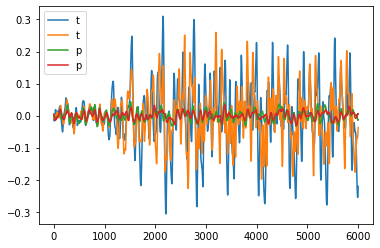

In [273]:
fig, ax = plt.subplots()
ax.plot(t.numpy(), label='t')
ax.plot(p.cpu().detach().numpy(), label='p')
plt.legend()
plt.show()
# sample['target'].shape, preds.shape

In [366]:
wav_path = '../data/wav/starks.wav'
waveform, sample_rate = torchaudio.load(wav_path)
waveform.shape, sample_rate

(torch.Size([2, 14038971]), 48000)

In [367]:
wf = torch.stack(dataset.sequence(waveform, SEQUENCE_LENGTH), dim=0)

In [368]:
def forecast(model, wf, n_steps):
    history = wf[:BATCH_SIZE].unsqueeze(0)
    for i in range(n_steps):
        next_step = model(history[-1].to(DEVICE))
        history = torch.cat((history, next_step.cpu().unsqueeze(0)), dim=0)
    return history.view(2, -1)

In [369]:
song = forecast(model, wf, 10).detach()

In [370]:
song.shape

torch.Size([2, 16896000])

In [371]:
waveform.shape

torch.Size([2, 14038971])

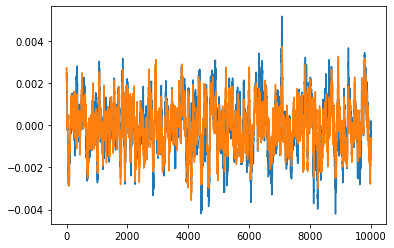

In [372]:
fig, ax = plt.subplots()
# ax.plot(waveform[:, -10000:].transpose(0, 1))
ax.plot(song[:, -10000:].transpose(0, 1))
plt.show()
# song[:,-100:]
# song[:, :10000].transpose(0, 1).shape
# waveform[:, :10000].transpose(0, 1).shape

In [373]:
torchaudio.save('outputs/raw/song2.wav', song, 48000)